# Data retrieval

In [1]:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [2]:
news_df = build_dataset(seed_urls)
news_df.head(10)


,news_headline,news_article,news_category
0,No one can be stopped from using my pic: Scarl...,Talking about her fake pornographic video that...,technology
1,Bill Gates calculated slices before cutting ou...,Microsoft Co-founder Bill Gates calculated the...,technology
2,iPhone XS Max explodes in pocket of a man's pa...,A US man named Josh Hillard has claimed his th...,technology
3,"Never made New Year's resolution, making one f...",Microsoft Co-founder and world's second riches...,technology
4,My 7-yr-old stepson allowed 1.5 hrs of screen ...,The 28-year-old billionaire Co-founder and CEO...,technology
5,No drone deployed for safety on New Year's due...,New York Police Department (NYPD) Chief said t...,technology
6,Cyber law to control tech firms comes into eff...,"Vietnam's cybersecurity law, which tightens go...",technology
7,Apply FDI norms on domestic online firms too: ...,Traders' body CAIT said the Foreign Direct Inv...,technology
8,Ex-Google workers' AI startup to make people '...,"Humu, an artificial intelligence (AI) startup ...",technology
9,US judge dismisses face recognition tech suit ...,A US judge dismissed a 2016 lawsuit which alle...,technology


In [3]:
news_df.news_category.value_counts()

technology    25
world         25
sports        25
Name: news_category, dtype: int64

# Text Wrangling and Pre-processing

In [4]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

nlp = spacy.load('en_core_web_md', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

# Remove HTML tags

In [5]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

# Remove accented characters

In [6]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

# Expand contractions

In [7]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

# Remove special characters

In [8]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

# Text lemmatization

In [9]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

# Text stemming

In [10]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

# Remove stopwords

In [11]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

# Building a text normalizer

In [12]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Pre-process and normalize news articles

In [13]:
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

In [14]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'clean_text': 'bill gate calculate slice cut wedding cake wife microsoft co founder bill gate calculate number slice serve guest cut wedding cake wife melinda gate reveal tuesday tell time cut cake think mean need cut slice everyone melinda say couple complete year marriage january',
 'full_text': 'Bill Gates calculated slices before cutting our wedding cake: Wife. Microsoft Co-founder Bill Gates calculated the number of slices that can serve the guests before cutting his wedding cake, his wife Melinda Gates revealed on Tuesday. "We told you it was time to cut the cake...You thought that meant you needed to cut a slice for everyone," Melinda said. The couple completed 25 years of marriage on January 1, 2019. '}

# Save the news articles

In [15]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

# Tagging Parts of Speech

In [16]:
news_df = pd.read_csv('news.csv')

In [17]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [18]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,Bill,NNP,PROPN
1,Gates,NNP,PROPN
2,calculated,VBD,VERB
3,slices,NNS,NOUN
4,before,IN,ADP
5,cutting,VBG,VERB
6,our,PRP$,ADJ
7,wedding,NN,NOUN
8,cake,NN,NOUN
9,:,:,PUNCT


In [19]:
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Bill,NNP
1,Gates,NNP
2,calculated,VBD
3,slices,NNS
4,before,IN
5,cutting,VBG
6,our,PRP$
7,wedding,VBG
8,cake:,NN
9,Wife,NNP


# Named Entity Recognition

In [20]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

In [21]:
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

[(Bill, 'PERSON'), (Gates, 'PERSON'), (Microsoft, 'ORG'), (Co, 'ORG'), (Bill, 'PERSON'), (Gates, 'PERSON'), (Melinda, 'PERSON'), (Gates, 'PERSON'), (Tuesday, 'DATE'), (Melinda, 'PERSON'), (25, 'DATE'), (years, 'DATE'), (January, 'DATE'), (1, 'DATE'), (,, 'DATE'), (2019, 'DATE')]


In [22]:
from spacy import displacy
displacy.render(sentence_nlp, style='ent', jupyter=True)

In [23]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [24]:
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,US,Indian,India,Australia,Google,Kohli,Pakistan,Australian,first,UNESCO,Sydney,NYPD,Ramakant Achrekar,Tuesday,New Years
Entity Type,GPE,NORP,GPE,GPE,ORG,PERSON,GPE,NORP,ORDINAL,ORG,GPE,ORG,PERSON,DATE,EVENT
Frequency,25,17,16,15,10,9,7,7,7,7,7,6,6,6,6


In [25]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,GPE,DATE,NORP,CARDINAL,EVENT,ORDINAL,FAC,TIME,MONEY,PRODUCT,LOC,WORK_OF_ART,QUANTITY
Frequency,149,147,133,66,53,52,22,12,9,8,4,3,3,2,2


In [26]:
from nltk.tag import StanfordNERTagger
import os

# set java path
java_path = r'C:\Program Files\Java\jdk1.8.0_191\bin\java.exe'
os.environ['JAVAHOME'] = java_path


# initialize NER tagger
sn = StanfordNERTagger('D:/stanford-ner-2014-08-27/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='D:/stanford-ner-2014-08-27/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])
                            

# view top entities and types
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)


# view top entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

C:\Anaconda3\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


,Entity Type,Frequency
0,PERSON,151
1,LOCATION,131
2,ORGANIZATION,84


# Sentiment Analysis with AFINN Lexicon

In [27]:
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
sports                   25.0  2.96  5.028916  -4.0  0.0  2.0  7.0  14.0
technology               25.0 -0.96  6.828128 -14.0 -4.0  0.0  1.0  10.0
world                    25.0 -3.84  6.478683 -17.0 -8.0 -4.0  0.0  11.0

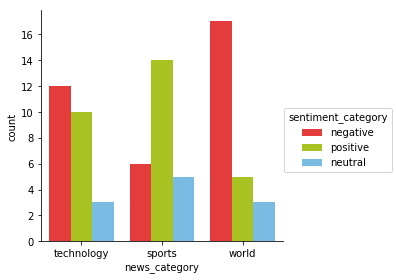

In [28]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [29]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 10)].index[0] #max value for new category
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -14)].index[0] #min value for new category

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Talking about her fake pornographic video that racked up over 1.5 million views, actress Scarlett Johansson has said, "Nothing can stop someone from cutting and pasting my image or anyone else's onto a different body." "This doesn't affect me...people assume it's not actually me in a porno, however demeaning it is," she said. "Fighting deepfake porn is fruitless," she added. 

Most Positive Tech News Article: According to a Privacy International study, at least 20 of 34 popular Android apps like TripAdvisor and Skyscanner send sensitive information to Facebook without users' permission. The shared information includes analytics data sent on launching the app like Android users' unique ID. This follows a previous report that said Facebook collected sensitive information from dating apps like Tinder.


In [30]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 14)].index[0] #max value for new category
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -4)].index[0] #min value for new category

print('Most Negative Sports News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Sports News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Sports News Article: Ex-India captain Sunil Gavaskar is reportedly set to miss handing over the Border-Gavaskar Trophy to India captain Virat Kohli after the fourth Australia-India Test in Sydney. Gavaskar, who is commentating on the series out of a studio in Mumbai, said that since Cricket Australia's ex-chief executive James Sutherland stepped down in October 2018, the Australian board has not contacted him.

Most Positive Sports News Article: Twenty-time Grand Slam champion Roger Federer took to Twitter to share a selfie with 23-time Grand Slam winner Serena Williams after defeating her in a mixed doubles match at Hopman Cup on Tuesday. "Oh what a night," the 37-year-old captioned the picture. This was the first time ever the duo played a professional match against each other. 


In [31]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 11)].index[0] #max value for new category
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -17)].index[0] #min value for new category

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: At least six people were killed and 16 others were injured on Wednesday in a train accident on Denmark's Great Belt Bridge, police said. The train accident, believed to be the worst in Denmark in 30 years, occurred when a passenger train braked suddenly after being hit by a flying object from a freight train during a heavy storm.

Most Positive World News Article: A signage beamed onto one of the Sydney Harbour Bridge pylons during New Year's celebrations had the words "Happy New Year 2018!" "We had one job Australia!! Happy new year anyway," a user tweeted, reacting to the gaffe. "It was a mistake but what we can clarify is that it is actually 2019," the event's executive producer Anna McInerney said. 


# Sentiment Analysis with TextBlob

In [33]:

from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()
                                     

sentiment_score                                                 \
                        count     mean       std    min    25%    50%    75%   
news_category                                                                  
sports                   25.0  0.09776  0.163083 -0.338  0.027  0.100  0.161   
technology               25.0  0.00440  0.185671 -0.386 -0.106  0.058  0.117   
world                    25.0  0.00120  0.127880 -0.200 -0.073  0.007  0.050   

                      
                 max  
news_category         
sports         0.525  
technology     0.343  
world          0.258

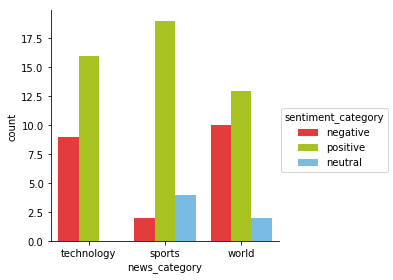

In [34]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [35]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.258)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.200)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: India and Pakistan on Tuesday exchanged a list of their nuclear installations and facilities under a bilateral agreement that prohibits both the countries from destroying each other's nuclear facilities. Under the agreement, both India and Pakistan inform each other of nuclear installations and facilities on January 1 of each calendar year. This is the 28th consecutive exchange of such list.

Most Positive World News Article: A signage beamed onto one of the Sydney Harbour Bridge pylons during New Year's celebrations had the words "Happy New Year 2018!" "We had one job Australia!! Happy new year anyway," a user tweeted, reacting to the gaffe. "It was a mistake but what we can clarify is that it is actually 2019," the event's executive producer Anna McInerney said. 


In [36]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 0.343)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -0.386)].index[0]

print('Most Negative Technology News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Technology News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: UK-based cybersecurity firm Insinia Security, which had recently hacked Twitter accounts of some celebrities to highlight a security flaw, has said users' accounts are still vulnerable to attacks. This comes after the microblogging platform had claimed it had fixed the flaw. The flaw could be used to "spread fake news and disinformation via influential celebrities and journalists," Insinia said.

Most Positive World News Article: Google has added a new feature to its Assistant which lets users in the US make donations to charitable organisations through it using commands like, "Ok Google, make a donation". Users can pick a monetary amount and an organisation of their choice to make their donation and would have to enable payments option to use the new feature.


In [38]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 0.525)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -0.338)].index[0]

print('Most Negative Sports News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Sports News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Sports News Article: Krishi Vigyan Kendra in Madhya Pradesh's Jhabua has written to the BCCI and India captain Virat Kohli, urging them to include Jhabua's Kadaknath chicken in players' diet. The letter mentioned Team India includes grilled chicken in its diet and due to higher cholesterol and fat in it, Kohli adopted vegan diet. Kadaknath chicken has low fat and cholesterol, it added.

Most Positive Sports News Article: Indian spinner Ravichandran Ashwin was seen undergoing a solo indoor bowling session while the rest of the Indian team preferred to take a day off ahead of the Sydney Test. Ashwin, who suffered a side strain during the first Test win in Adelaide, was accompanied by the Indian team's physiotherapist Patrick Farhart during the training session.
